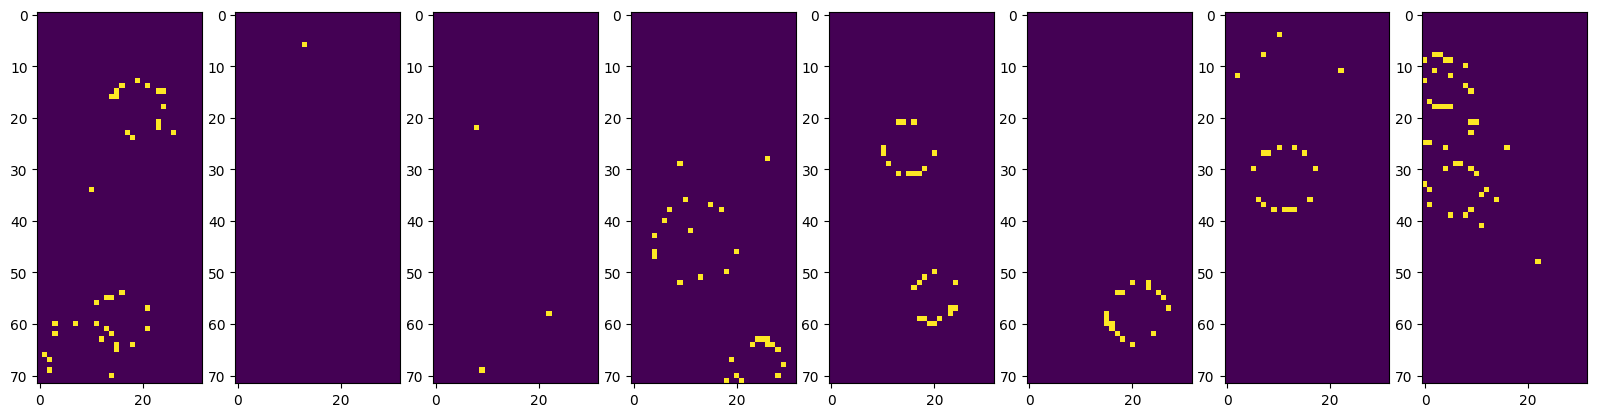

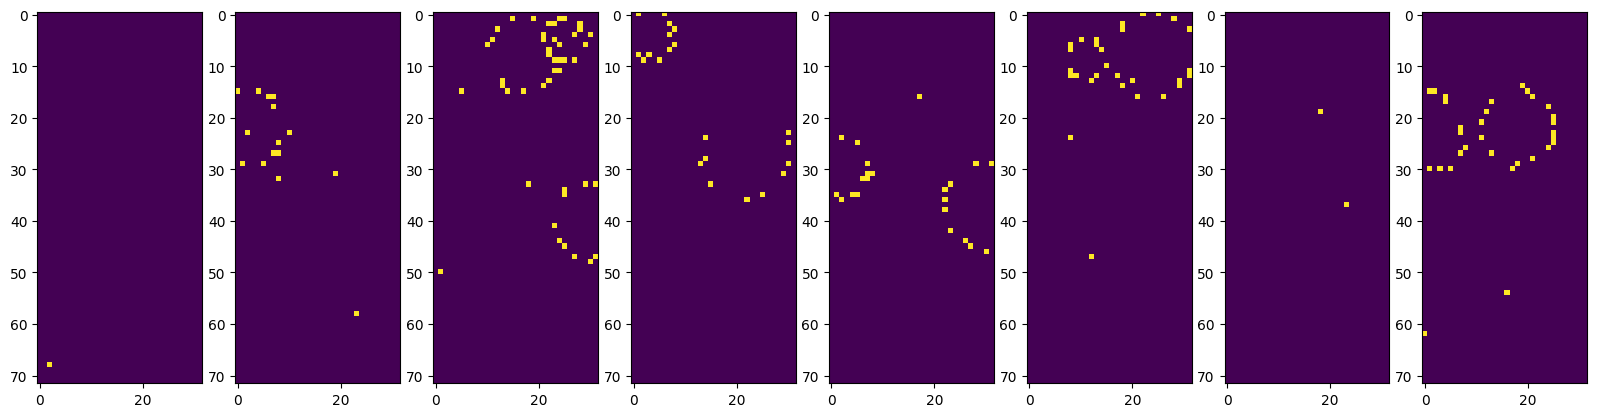

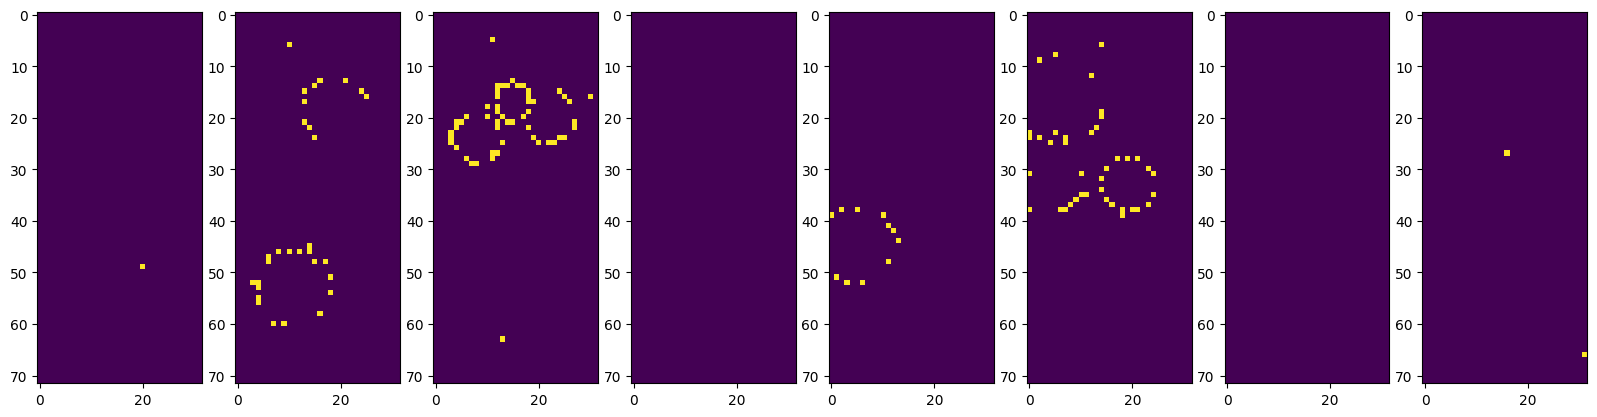

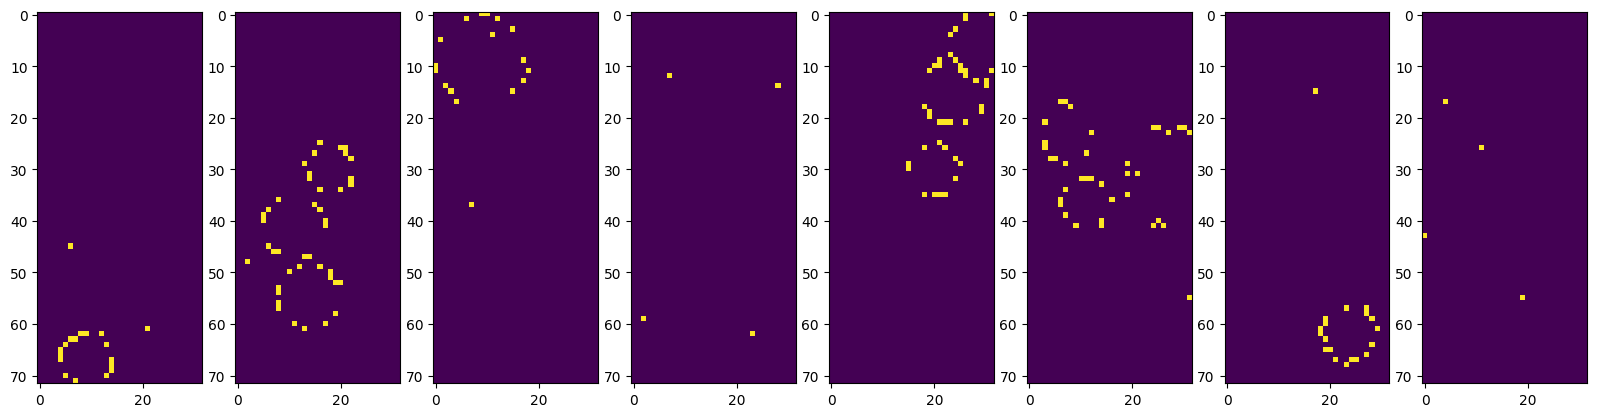

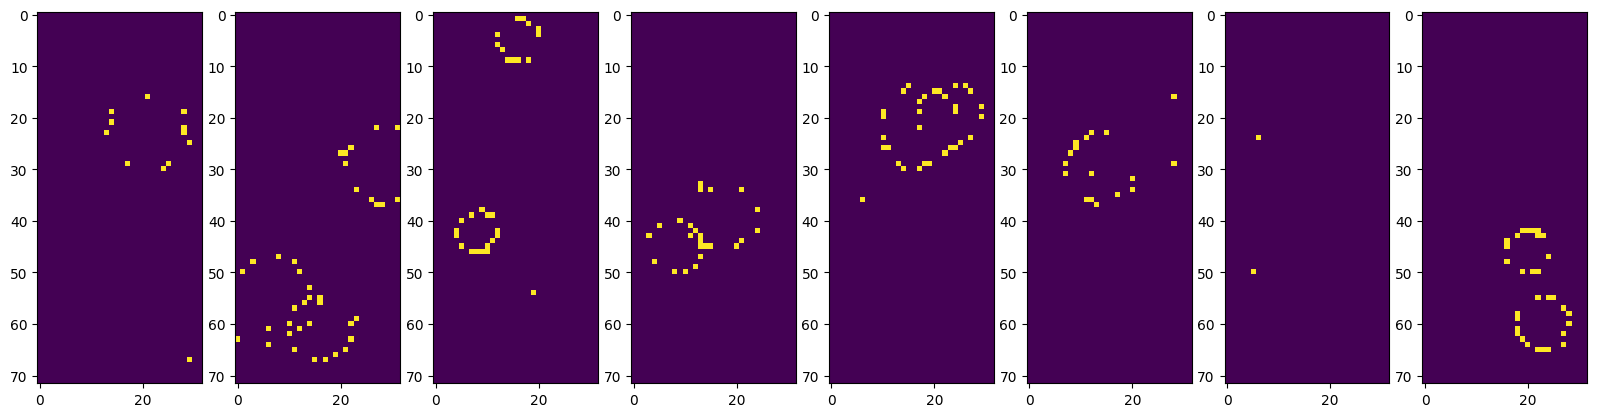

In [2]:
#!/usr/bin/env python3
import sys, os
sys.path.append("..")

from model import *
from utils import *
from sweep_configs import *
from wandb.keras import WandbCallback
from create_data import *
from train import *
%matplotlib inline

## ---------------------- load data ----------------------------------------
ins, os, hpr, rn = (72,32,1), 15, (10, 20), 0.05
gen = DataGen(ins, hpr, rn)
x, y = gen.create_dataset(500)

display_images(1, 8, x, 5)

## Real/Sim data (mcbm)

load data from  ../data/features.csv  -> 1000  events loaded


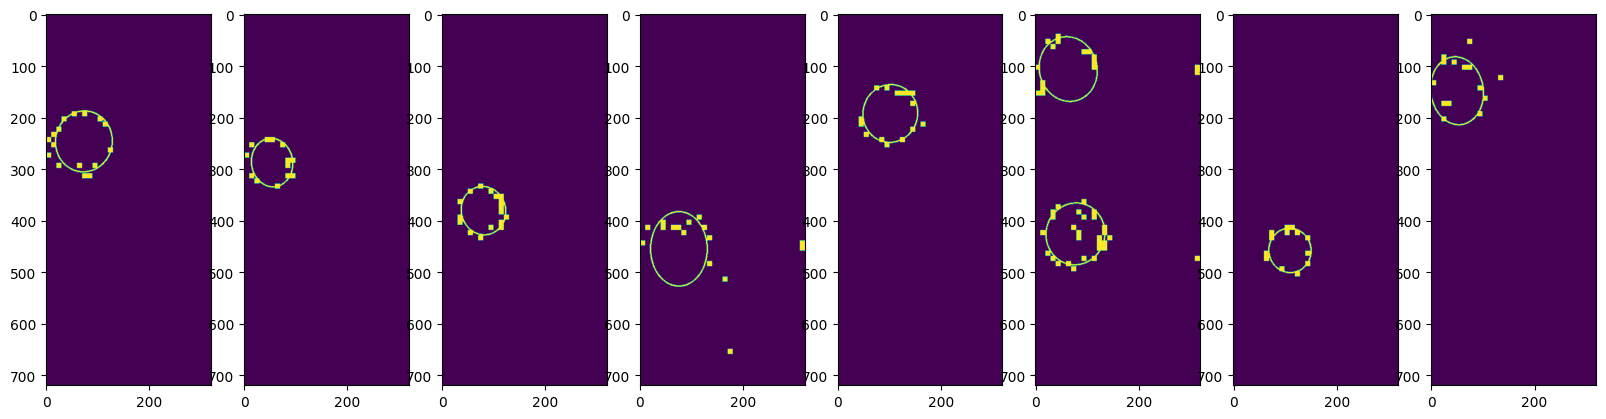

In [2]:
sim_x = np.array(loadFeatures("../data/features.csv"))
#sim_x = np.array([cv2.merge((a,a,a)) for a in sim_x])
ideal_hough_y = loadParameters("../data/targets.csv")
sim_x, ideal_hough_y = filter_events(sim_x, ideal_hough_y) # filter events with incorrectly fitted rings

ideal_hough_y = ideal_hough_y.reshape((sim_x.shape[0],5,5))

hough = np.array([plot_single_event(sim_x[i], ideal_hough_y[i]) for  i in range(sim_x.shape[0])])
display_images(1,8, hough, 1)

## Comparison

In [9]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

model = tf.keras.models.load_model("../models/checkpoints/200k-202206211810.model/")
#model.evaluate(X, y)

pred_sim = model.predict(sim_x)
pred_toymodel = model.predict(x)

# simulation
predictions_sim = np.array([plot_single_event(sim_x[i], pred_sim[i]) for  i in range(sim_x.shape[0])])
#display_images(1, 8, predictions_sim, 5)

# toymodel
predictions_toymodel = np.array([plot_single_event(x[i], pred_toymodel[i]) for  i in range(x.shape[0])])
#display_images(1, 8, predictions_toymodel, 5)

from time import time
t1 = time()
model.predict(x)
tfp = time() - t1
print("Time for predicting {} events: {} ({}s/event)".format(x.shape[0], tfp, tfp/x.shape[0]))

4/4 [==============================] - 0s 6ms/step
Time for predicting 100 events: 0.05566716194152832 (0.0005566716194152832s/event)


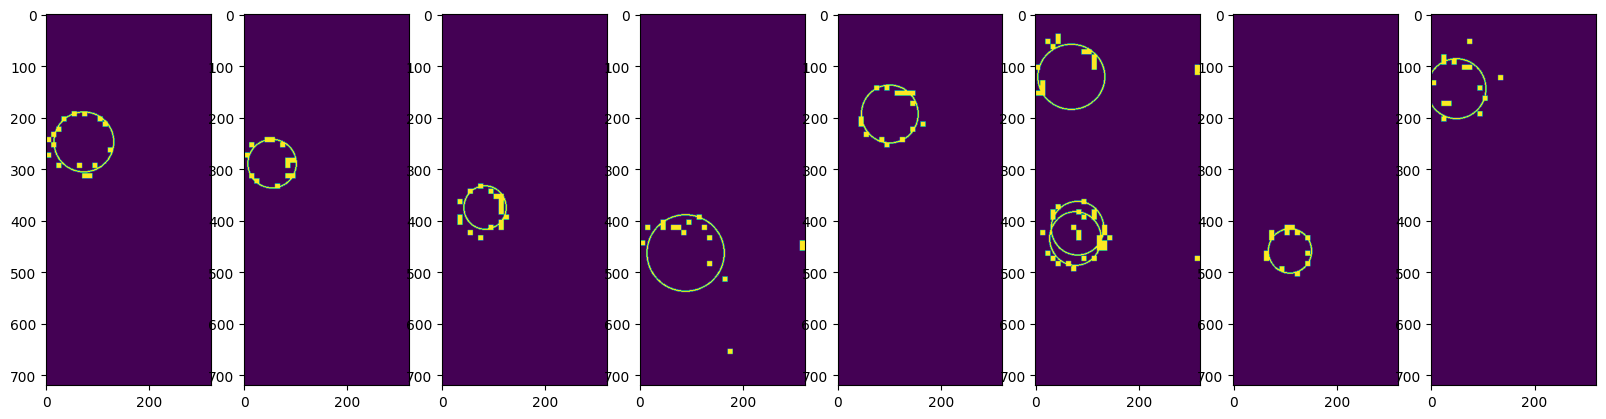

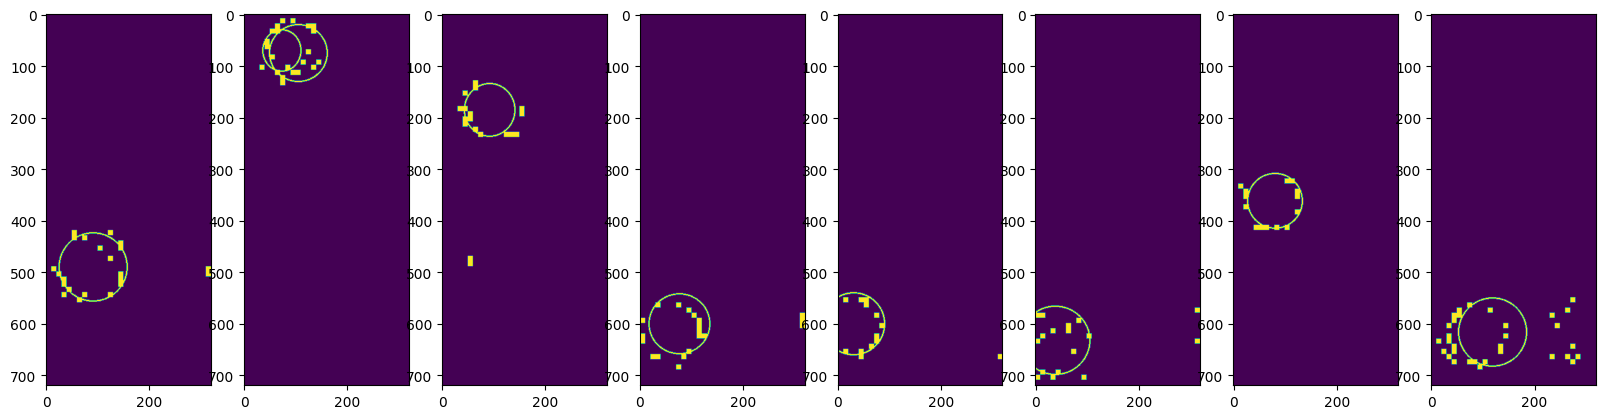

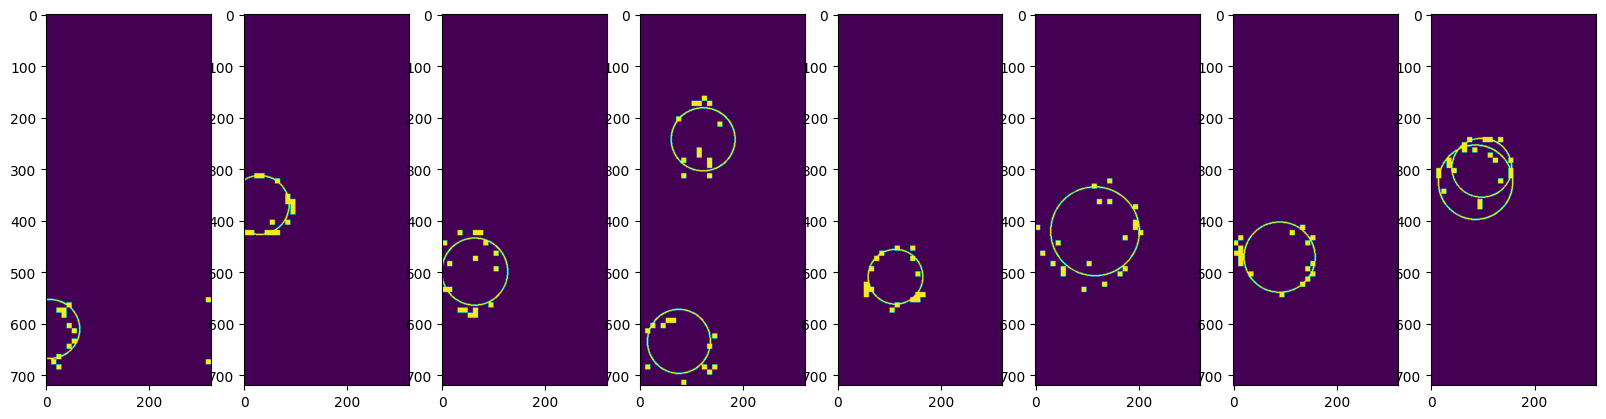

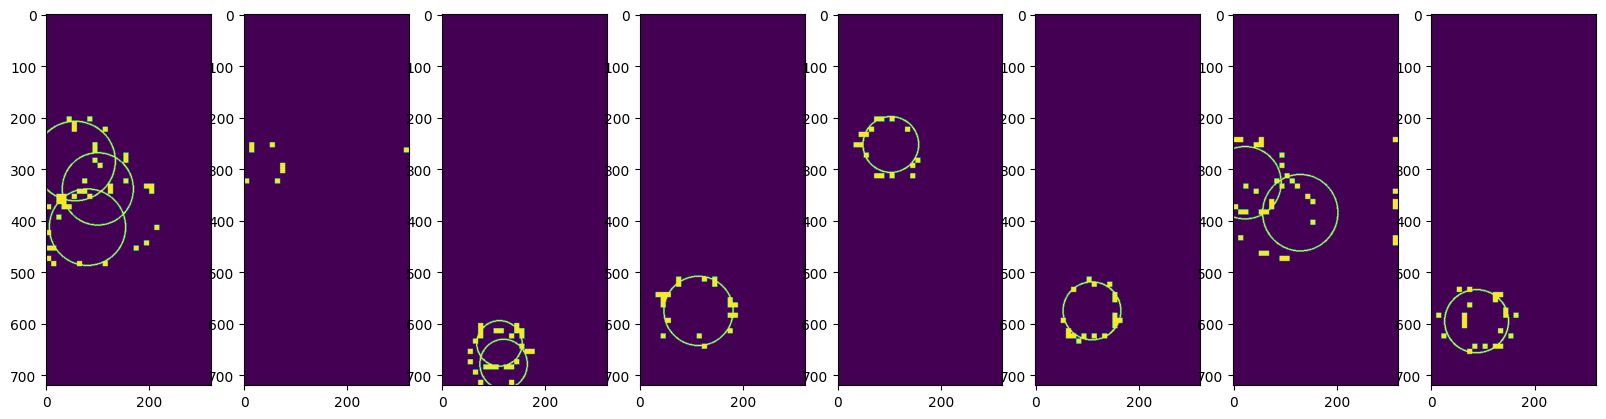

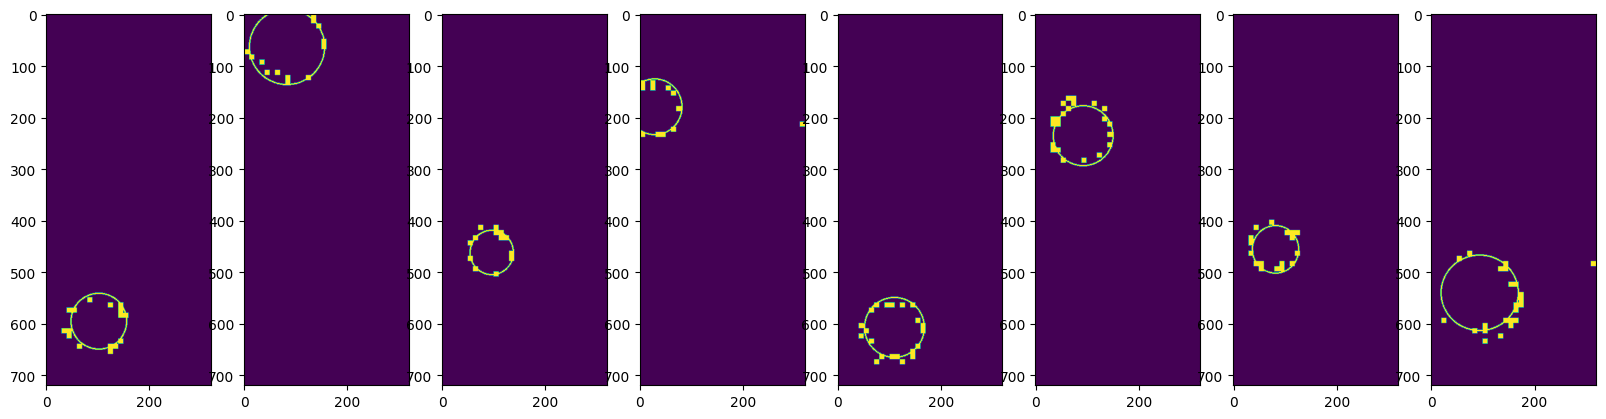

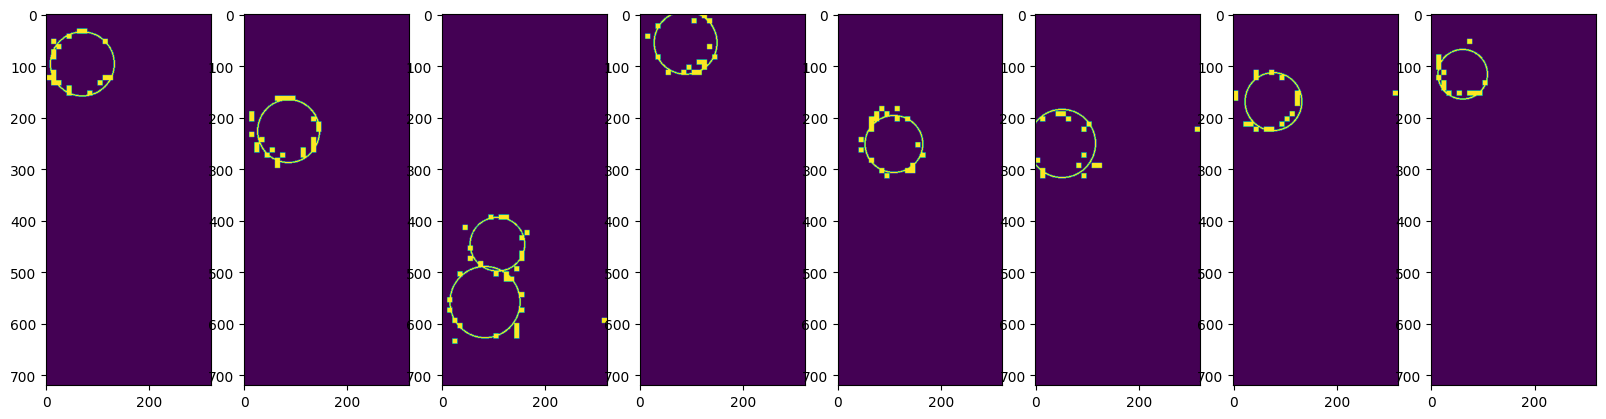

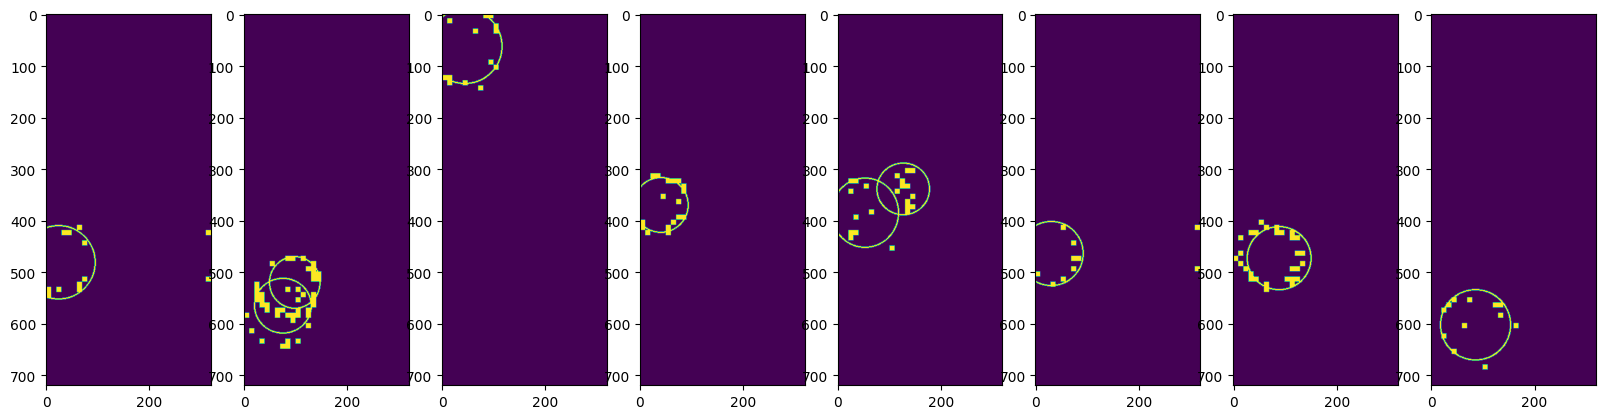

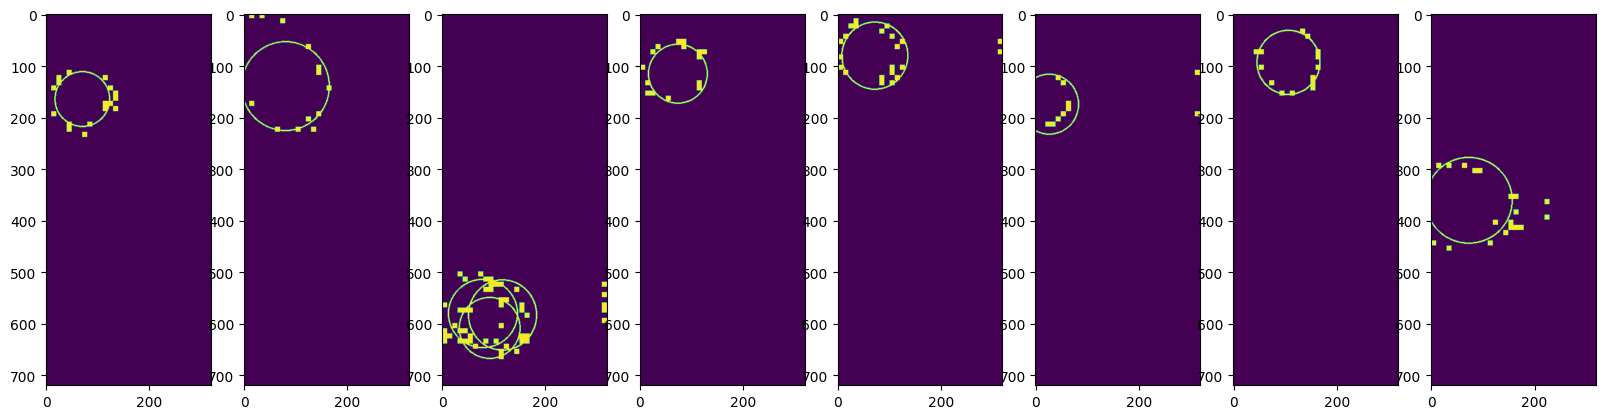

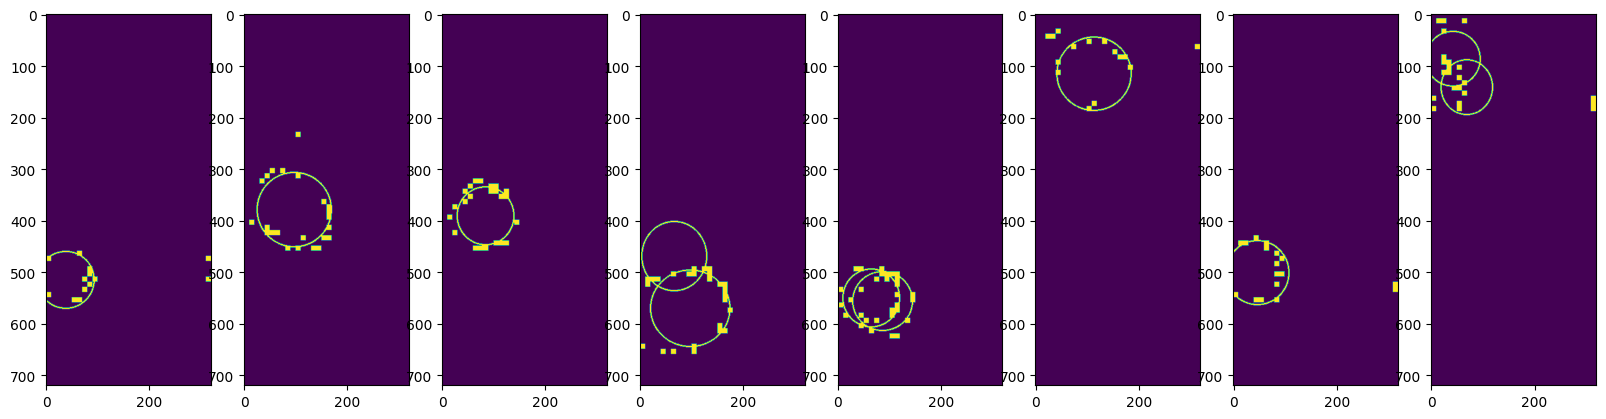

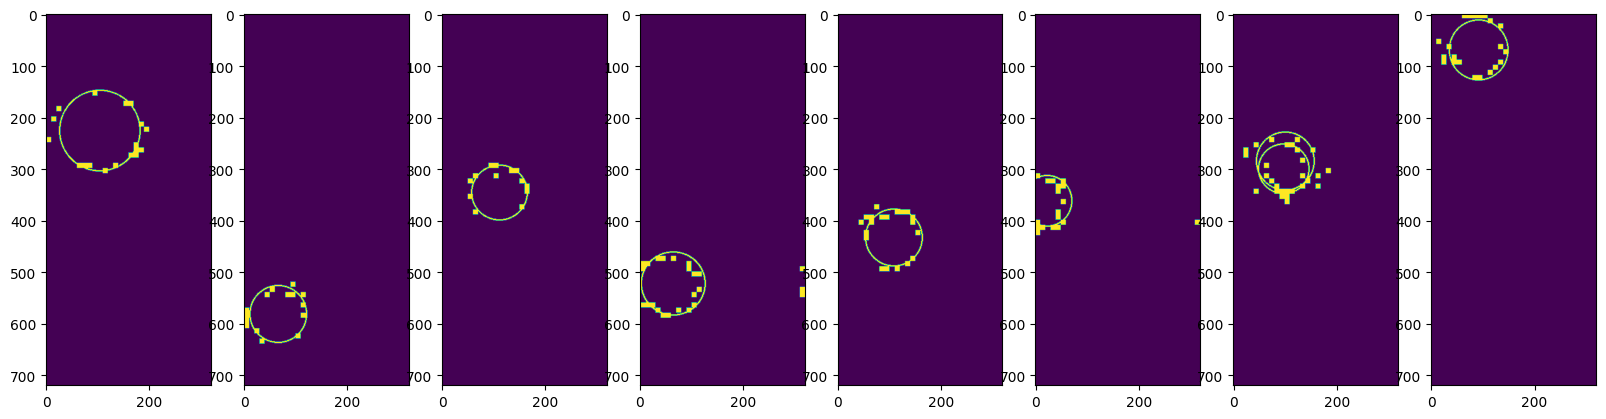

In [15]:
for i in range(pred_sim.shape[0]):
#    fig, ax = plt.subplots(1,5)
#    ax[0].imshow(predictions_sim[i])
    for j in range(pred_sim[0].shape[0]):
        ring = pred_sim[i][j].astype(int)
        x1 = ring[1]-ring[3] - 1
        x2 = ring[1]+ring[3] + 1
        y1 = ring[0]-ring[2] - 1
        y2 = ring[0]+ring[2] + 1

        if x1 < 0: x1 = 0
        if y1 < 0: y1 = 0
        if x2 > sim_x.shape[1]: x2 = sim_x.shape[1]
        if y2 > sim_x.shape[2]: y2 = sim_x.shape[2]

        crop = sim_x[i][x1:x2,y1:y2]

        if len(np.where(crop == 1)[0]) < 5:
            pred_sim[i][j] = np.zeros(5)
                
#            ax[j+1].imshow(crop)
#    plt.show()
filtered_predictions_sim = np.array([plot_single_event(sim_x[i], pred_sim[i]) for  i in range(sim_x.shape[0])])
display_images(1, 8, filtered_predictions_sim, 10)